In [1]:
import ltspice
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [2]:
path = 'Draft1.raw'

In [3]:
l = ltspice.Ltspice(path)
l.parse()
x_data = l.get_data('V(n001)')
y_data = []
gs_data = []
time = l.get_time()
for case in range(l.case_count):
    time = l.get_time(case)
    y_data.append(l.get_data('Id(M1)', case))
    gs_data.append(l.get_data('V(n002)', case)[0])

In [4]:
def unified_model(Vth, k, l = 0, vdsat = 9999):
    # This function constructs the model
    def model(Vds, Vgs):
        Vgt = Vgs - Vth
        Vmin = min((Vds, Vgt, vdsat))
        return 0.5 * k * (Vgt * Vmin - 0.5 * pow(Vmin, 2)) * (1 + l * Vds)
    return model

In [5]:
def plot_model(model, Vgs, colour):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    x_vals = np.arange(start=x_vals[0], stop=x_vals[1], step=0.01)
    y_vals = []
    for x_val in x_vals:
        y_vals.append(model(x_val, Vgs))
    plt.plot(x_vals, y_vals, '--', color=colour)

In [6]:
def dist(x_data, y_data, model):
    dist = 0
    for idx, y in enumerate(y_data):
        model_y = []
        for x in x_data:
            y_value = model(x, gs_data[idx])
            model_y.append(y_value)
        model_dist = np.linalg.norm(y - model_y)
        dist += model_dist
    return dist

In [7]:
def optimize_vdsat(x, y, start, step, stepfactor, stepend, technology):
    start_model = unified_model(technology[0], technology[1], technology[2], start)
    prev_dist = dist(x, y, start_model)
    factor = 1
    vdsat = start
    while True:
        model = unified_model(technology[0], technology[1], technology[2], vdsat - factor * step)
        new_dist = dist(x, y, model)
        if new_dist < prev_dist:
            prev_dist = new_dist
            vdsat = vdsat - factor * step
        else:
            model = unified_model(technology[0], technology[1], technology[2], vdsat + factor * step)
            new_dist = dist(x, y, model)
            if new_dist < prev_dist:
                prev_dist = new_dist
                vdsat = vdsat + factor * step
            else:
                factor = factor * stepfactor
                if factor < stepend:
                    break
    return vdsat


0.5315902709960937


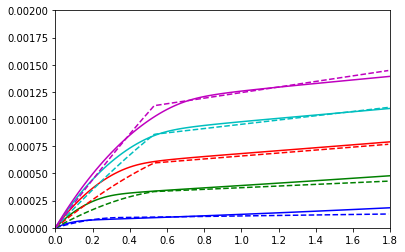

In [8]:
# model1 = unified_model(0.236, 0.002902, 0.26, 0.55)
plt.ylim(bottom=0., top=0.002)
plt.xlim(left=0., right=1.8)
technology = (0.2546, 0.002902, 0.26) # Vt0, k, lambda
vdsat = optimize_vdsat(x_data, y_data, 0.5, 0.1, 0.5, 0.00001, technology)
model1 = unified_model(technology[0], technology[1], technology[2], vdsat)
colours = ['b', 'g', 'r', 'c', 'm']
print(vdsat)
for idx, data in enumerate(y_data):
    Id = data
    Vds = x_data
    # plt.plot(Vds, sqrt_id)
    plt.plot(Vds, Id, color=colours[idx])
    plot_model(model1, gs_data[idx], colours[idx])
plt.savefig('graph_old_vt0.svg')
plt.show()
